In [1]:
import os
import re

import numpy as np
import tensorflow as tf

np.random.seed(1)
tf.random.set_seed(44)
tf.config.experimental.enable_op_determinism()

import pandas as pd
import keras
# from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import class_weight
from sklearn.metrics import f1_score, classification_report, log_loss

from keras.preprocessing.text import Tokenizer
# from keras.preprocessing.sequence import pad_sequences
from keras.utils import pad_sequences
from keras.utils import to_categorical

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D, Bidirectional, Flatten
from keras.layers import Dropout, Conv1D, GlobalMaxPool1D, GRU, GlobalAvgPool1D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ModelCheckpoint, EarlyStopping

import keras.metrics as km


In [2]:
train = pd.read_csv('cleaned_df/stance_climate_train_cleaned.csv')
test = pd.read_csv('cleaned_df/stance_climate_test_cleaned.csv')
validation = pd.read_csv('cleaned_df/stance_climate_validation_cleaned.csv')

In [3]:
# Mapping of common contractions
CONTRACTION_MAPPING1 = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", 
                       "couldn't": "could not", "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", 
                       "hasn't": "has not", "haven't": "have not", "he'd": "he would","he'll": "he will", "he's": "he is", 
                       "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",  "I'd": "I would", 
                       "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", 
                       "i'd": "i would", "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", 
                       "i've": "i have", "isn't": "is not", "it'd": "it would", "it'd've": "it would have", "it'll": "it will", 
                       "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam", "mayn't": "may not", 
                       "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have", 
                       "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
                       "o'clock": "of the clock", "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", 
                       "sha'n't": "shall not", "shan't've": "shall not have", "she'd": "she would", "she'd've": "she would have", 
                       "she'll": "she will", "she'll've": "she will have", "she's": "she is", "should've": "should have", 
                       "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as", 
                       "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", 
                       "there'd": "there would", "there'd've": "there would have", "there's": "there is", "here's": "here is",
                       "they'd": "they would", "they'd've": "they would have", "they'll": "they will", "they'll've": 
                       "they will have", "they're": "they are", "they've": "they have", "to've": "to have", "wasn't": "was not", 
                       "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", 
                       "we're": "we are", "we've": "we have", "weren't": "were not", "what'll": "what will", 
                       "what'll've": "what will have", "what're": "what are",  "what's": "what is", "what've": "what have", 
                       "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is", 
                       "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", 
                       "who've": "who have", "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", 
                       "won't've": "will not have", "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", 
                       "y'all": "you all", "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
                       "y'all've": "you all have","you'd": "you would", "you'd've": "you would have", "you'll": "you will", 
                       "you'll've": "you will have", "you're": "you are", "you've": "you have", "It's": 'It is', "Can't": 'Can not',
                      }

In [4]:
# Mapping of common contractions, no apostrophes 
CONTRACTION_MAPPING2 = {"aint": "is not", "arent": "are not","cant": "cannot", "'cause": "because", "cos": "because", "couldve": "could have", 
                       "couldnt": "could not", "didnt": "did not",  "doesnt": "does not", "dont": "do not", "hadnt": "had not", 
                       "hasnt": "has not", "havent": "have not", "hed": "he would","hell": "he will", "hes": "he is", 
                       "howd": "how did", "how'd'y": "how do you", "howll": "how will", "hows": "how is",  "Id": "I would", 
                       "Idve": "I would have", "Ill": "I will", "Illve": "I will have","Im": "I am", "Ive": "I have", 
                       "id": "i would", "idve": "i would have", "ill": "i will",  "illve": "i will have", "im": "i am", 
                       "ive": "i have", "isnt": "is not", "itd": "it would", "itdve": "it would have", "itll": "it will", 
                       "itllve": "it will have","its": "it is", "lets": "let us", "maam": "madam", "maynt": "may not", 
                       "mightve": "might have","mightnt": "might not","mightntve": "might not have", "mustve": "must have", 
                       "mustnt": "must not", "mustntve": "must not have", "neednt": "need not", "needntve": "need not have",
                       "o'clock": "of the clock", "oughtnt": "ought not", "oughtntve": "ought not have", "shant": "shall not", 
                       "shant": "shall not", "shantve": "shall not have", "shed": "she would", "shedve": "she would have", 
                       "shell": "she will", "shellve": "she will have", "shes": "she is", "shouldve": "should have", 
                       "shouldnt": "should not", "shouldntve": "should not have", "sove": "so have", 
                       "thatd": "that would", "thatdve": "that would have", "thats": "that is", 
                       "thered": "there would", "theredve": "there would have", "theres": "there is", "heres": "here is",
                       "theyd": "they would", "theydve": "they would have", "theyll": "they will", "theyllve": 
                       "they will have", "theyre": "they are", "theyve": "they have",  "wasnt": "was not", 
                       "wed": "we would", "wedve": "we would have", "wellve": "we will have", 
                        "weve": "we have", "werent": "were not", "whatll": "what will", "hell": "he will",
                       "whatllve": "what will have", "whatre": "what are",  "whats": "what is", "whatve": "what have", 
                       "whens": "when is", "whenve": "when have", "whered": "where did", "wheres": "where is", 
                       "whereve": "where have", "wholl": "who will", "whollve": "who will have", "whos": "who is", 
                       "whove": "who have", "whys": "why is", "whyve": "why have", "willve": "will have", "wont": "will not", 
                       "wontve": "will not have", "wouldve": "would have", "wouldnt": "would not", "wouldntve": "would not have", 
                       "yall": "you all", "yalld": "you all would","yalldve": "you all would have",
                       "youd": "you would", "youdve": "you would have", "youll": "you will", 
                       "youllve": "you will have", "youre": "you are", "youve": "you have", "Its": 'It is', "Cant": 'Can not',
                      }

Determine optimal batch size

In [5]:
#training constants
MAX_SEQ_LEN = train['text'].apply(lambda x : len(x.split(' '))).quantile(0.95)
DEFAULT_BATCH_SIZE = 128

print(MAX_SEQ_LEN)

17.0


Data cleaning

In [6]:
def clean_text(text, mapping):
    replace_white_space = ["\n"]
    for s in replace_white_space:
        text = text.replace(s, " ")
    replace_punctuation = ["’", "‘", "´", "`", "\'", r"\'"]
    for s in replace_punctuation:
        text = text.replace(s, "'")

    mapped_string = []
    for t in text.split(" "):
        if t in mapping:
            mapped_string.append(mapping[t])
        elif t.lower() in mapping:
            mapped_string.append(mapping[t.lower()])
        else:
            mapped_string.append(t)
    return ' '.join(mapped_string)

In [7]:
# Get tweets from Data frame and convert to list of "texts" scrubbing based on clean_text function
# CONTRACTION_MAPPING is a map of common contractions(e.g don't => do not)
train_text_vec = [clean_text(text, CONTRACTION_MAPPING1) for text in train['text'].values]
test_text_vec = [clean_text(text, CONTRACTION_MAPPING1) for text in test['text'].values]
validation_vec = [clean_text(text, CONTRACTION_MAPPING1) for text in validation['text'].values]

train_text_vec = [clean_text(text, CONTRACTION_MAPPING2) for text in train['text'].values]
test_text_vec = [clean_text(text, CONTRACTION_MAPPING2) for text in test['text'].values]
validation_vec = [clean_text(text, CONTRACTION_MAPPING2) for text in validation['text'].values]

Tokenizing and padding

In [8]:
# tokenize the sentences
tokenizer = Tokenizer(lower=False)
tokenizer.fit_on_texts(train_text_vec)
train_text_vec = tokenizer.texts_to_sequences(train_text_vec)
test_text_vec = tokenizer.texts_to_sequences(test_text_vec)
validation_vec = tokenizer.texts_to_sequences(validation_vec)

# pad the sequences
train_text_vec = pad_sequences(train_text_vec, maxlen=MAX_SEQ_LEN)
test_text_vec = pad_sequences(test_text_vec, maxlen=MAX_SEQ_LEN)
validation_vec = pad_sequences(validation_vec, maxlen=MAX_SEQ_LEN)

print('Number of Tokens:', len(tokenizer.word_index))
print('Max Token Index:', train_text_vec.max(), "\n")

print('Sample Tweet Before Processing:', train['text'].values[73])
print('Sample Tweet After Processing:', tokenizer.sequences_to_texts([train_text_vec[73]]), '\n')

print('What the model will interpret:', train_text_vec[0].tolist())

Number of Tokens: 1891
Max Token Index: 1891 

Sample Tweet Before Processing: really cant stand the catholic church but think have crush popefrancis shhhh dont tell animalrights
Sample Tweet After Processing: ['really cannot stand the catholic church but think have crush popefrancis shhhh do not tell animalrights'] 

What the model will interpret: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 28, 1, 88, 542, 303, 543, 200]


In [9]:
# One Hot Encode Y values:
encoder = LabelEncoder()

y_train = encoder.fit_transform(train['label'].values)
y_train = to_categorical(y_train) 

y_test = encoder.fit_transform(test['label'].values)
y_test = to_categorical(y_test) 

y_validation = encoder.fit_transform(validation['label'].values)
y_validation = to_categorical(y_validation) 

In [10]:
# get an idea of the distribution of the text values
from collections import Counter
ctr = Counter(train['label'].values)
print('Distribution of Classes:', ctr)

# get class weights for the training data, this will be used data
y_train_int = np.argmax(y_train,axis=1)

cws = class_weight.compute_class_weight(class_weight = "balanced", 
                                        classes = np.unique(y_train_int),
                                        y = y_train_int)
cws = {i : cws[i] for i in range(3)}
print(cws)

Distribution of Classes: Counter({2: 191, 0: 147, 1: 13})
{0: 0.7959183673469388, 1: 9.0, 2: 0.612565445026178}


## Building a neural network model 

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

optimizer = RMSprop(learning_rate=0.01)
np.set_printoptions(precision=4)

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """

    target_names = ['none', 'against', 'favour']
    _cm = confusion_matrix(y_true, y_pred)
    
    print(classification_report(y_true, y_pred, target_names=target_names))

        
    def _build_matrix(fig, ax, cm, normalize = False):
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
        
        if normalize:
            cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        im = ax.imshow(cm, cmap=cmap)
#         fig.colorbar(im, ax=ax)
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=target_names, 
               yticklabels=target_names,
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        
    fig, [ax1, ax2] = plt.subplots(nrows = 1, ncols = 2, figsize=(8, 4))
    _build_matrix(fig, ax1, cm = _cm, normalize=False)
    _build_matrix(fig, ax2, cm = _cm, normalize=True)
    fig.tight_layout()

In [12]:
from sklearn.metrics import recall_score, precision_score

def threshold_search(y_true, y_proba, average = None):
    best_threshold = 0
    best_score = 0
    for threshold in [i * 0.01 for i in range(100)]:
        score = f1_score(y_true=y_true, y_pred=y_proba > threshold, average=average)
        if score > best_score:
            best_threshold = threshold
            best_score = score
    search_result = {'threshold': best_threshold, 'f1': best_score}
    return search_result


def train_model(model, 
          X_train, y_train, X_test, y_test, X_validation, y_validation,
          class_weights,
          checkpoint_path, 
          epcohs = 25, 
          batch_size = DEFAULT_BATCH_SIZE, 
           
          fit_verbose=2,
          print_summary = True
         ):
    m = model()
    if print_summary:
        print(m.summary())
    m.fit(
        X_train, 
        y_train, 
        validation_data=(X_validation, y_validation),  
        epochs=epcohs, 
        batch_size=batch_size,
        class_weight=class_weights,
         #saves the most accurate model, usually you would save the one with the lowest loss
        callbacks= [
            ModelCheckpoint(checkpoint_path, monitor='val_acc', verbose=1, save_best_only=True),
            EarlyStopping(patience = 2)
        ],
        verbose=fit_verbose
    ) 

    m.save_weights(checkpoint_path.format(epoch=0))

    print("\n\n****************************\n\n")
    print('Loading Best Model...')
    m.load_weights(checkpoint_path)
    predictions = m.predict(X_test, verbose=1)

    # recall = recall_score(y_test, predictions, average='weighted') * 100
    # precision = precision_score(y_test, predictions, average='weighted') * 100
    
    # print(f'Precision: {precision:.2f}')
    # print(f'Recall: {recall:.2f}')

    print('Validation Loss:', log_loss(y_test, predictions))
    print('Test Accuracy', (predictions.argmax(axis = 1) == y_test.argmax(axis = 1)).mean())
    print('F1 Score:', f1_score(y_test.argmax(axis = 1), predictions.argmax(axis = 1), average='weighted'))
    
    plot_confusion_matrix(y_test.argmax(axis = 1), predictions.argmax(axis = 1), classes=encoder.classes_)
    plt.show()   
     
    return m #returns best performing model



### Simple LSTM

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 18, 128)           242176    
                                                                 
 lstm (LSTM)                 (None, 128)               131584    
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 3)                 195       
                                                                 
Total params: 382,211
Trainable params: 382,211
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/25
3/3 - 4s - loss: 4.5555 - accuracy: 0.3333 - precision: 0.0515 - recall: 0.0142 - val_loss: 1.0537 - val_accuracy: 0.4000 - val_precision: 0.4324 - val_recall: 0.4000

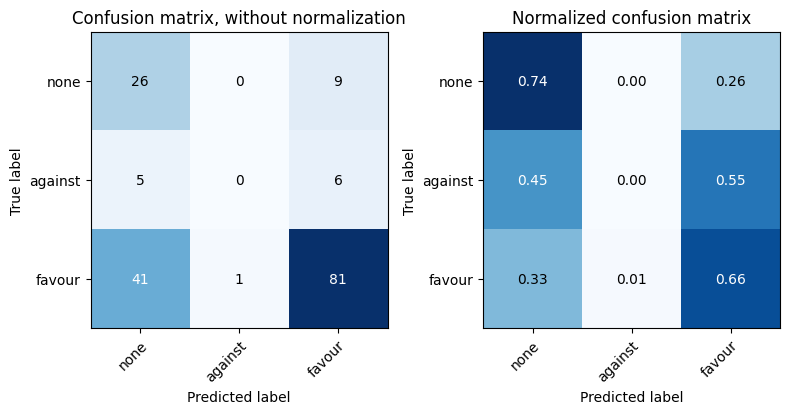

In [13]:
def model_1():
    """
    Using a Simple LSTM. 
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(LSTM(128))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                   metrics=['accuracy', km.Precision(), km.Recall()])
    return model

m1 = train_model(model_1, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           class_weights=cws,
           checkpoint_path='saved_models/climate/model_1a.h5',
          )

### Bi-Directional LSTM

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 18, 128)           242176    
                                                                 
 spatial_dropout1d (SpatialD  (None, 18, 128)          0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 256)              263168    
 l)                                                              
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 3)                

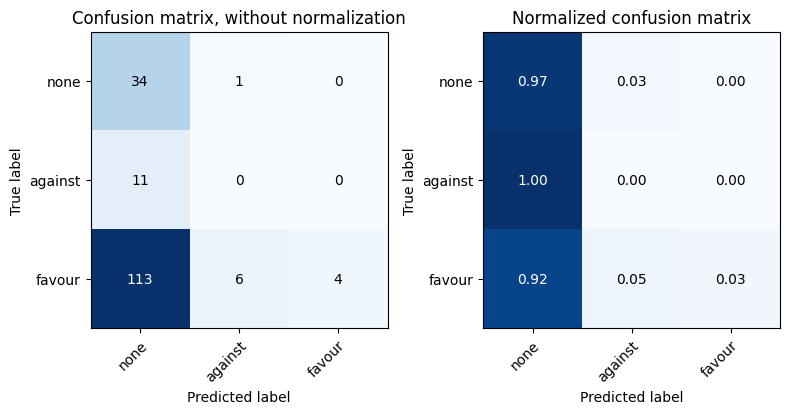

In [14]:
def model_1b():
    """
    Using a Bidiretional LSTM. 
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25)))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy', km.Precision(), km.Recall()])
    return model

m1b = train_model(model_1b, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/climate/model_1b.h5',
           class_weights=cws,
           print_summary = True
          )

### Including convolutions

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 18, 128)           242176    
                                                                 
 spatial_dropout1d_1 (Spatia  (None, 18, 128)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 18, 256)          263168    
 nal)                                                            
                                                                 
 conv1d (Conv1D)             (None, 15, 64)            65600     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                                  
                                                      

c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

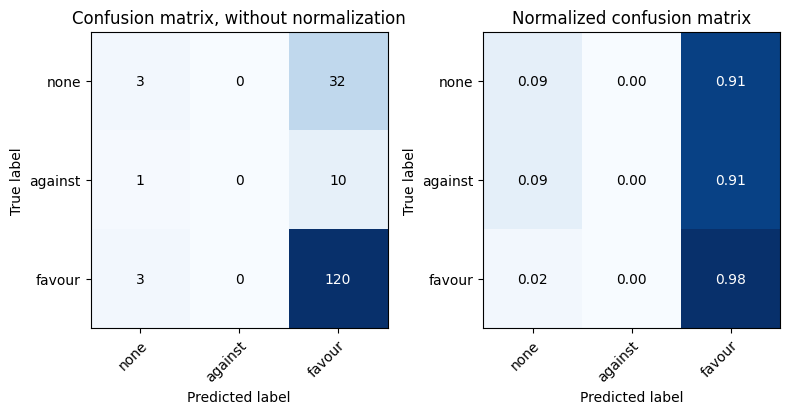

In [15]:
def model_1c():
    """
    Adding dropout to reduce overfitting using a bidiretional LSTM
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
#     model.add(Flatten())
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                  metrics=['accuracy', km.Precision(), km.Recall()])
#     print(model.summary())
    return model


m1c = train_model(model_1c, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/climate/model_1c.h5',
           class_weights=cws,
           print_summary = True
          )

Including dropout

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 18, 128)           242176    
                                                                 
 bidirectional_2 (Bidirectio  (None, 18, 512)          788480    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 18, 512)           0         
                                                                 
 lstm_4 (LSTM)               (None, 18, 128)           328192    
                                                                 
 dropout_2 (Dropout)         (None, 18, 128)           0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                      

c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

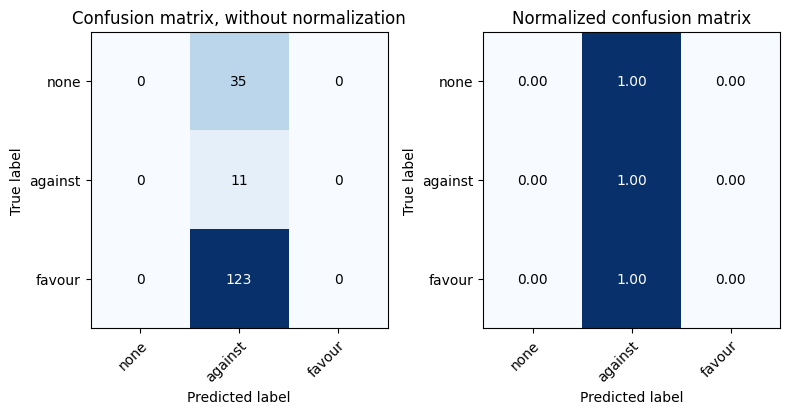

In [16]:
def model_1d():
    """
    Experimenting with other specifications
    """
    model = Sequential()
    model.add(Embedding(input_dim = (len(tokenizer.word_counts) + 1), output_dim = 128, input_length = MAX_SEQ_LEN))
    model.add(Bidirectional(LSTM(256, return_sequences=True, recurrent_dropout=0.2, dropout=0.2), 'concat'))
    model.add(Dropout(0.4))
    model.add(LSTM(128, return_sequences=True, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dropout(0.4))
    model.add(LSTM(64, return_sequences=False, recurrent_dropout=0.2, dropout=0.2))
    model.add(Dropout(0.2))
    model.add(Dense(64, activation='sigmoid'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss ='categorical_crossentropy', 
                  optimizer = optimizer, 
                  metrics = ['accuracy', km.Precision(), km.Recall()])
    return model


m1d = train_model(model_1d, 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/climate/model_1d.h5',
           class_weights=cws,
           print_summary = True
          )

### Using transfer learning

In [17]:
import gensim.downloader as api

tw25_model = api.load("glove-twitter-25")
tw100_model = api.load("glove-twitter-100")


In [18]:
word_index = tokenizer.word_index

def get_embeddings_matrix(embedding_model, word_index):

    embedding_dim = embedding_model.vector_size

    # Create the embedding matrix for vocabulary
    embedding_matrix = np.zeros(((len(tokenizer.word_counts) + 1), embedding_dim))
    for word, i in word_index.items():
        if word in embedding_model.key_to_index:
            embedding_matrix[i] = embedding_model.get_vector(word)
    
    return embedding_matrix
        

In [19]:
def model_2(embed_matrix):
    """
    Extends model_1 with a glove embedding
    """
    model = Sequential()
    model.add(Embedding(input_dim = embed_matrix.shape[0], 
                        output_dim = embed_matrix.shape[1], 
                        input_length = MAX_SEQ_LEN,  
                        weights=[embed_matrix], 
                        trainable=False))
    model.add(SpatialDropout1D(0.3))
    model.add(Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25, return_sequences=True)))
    model.add(Conv1D(64, 4))
#     model.add(Flatten())
    model.add(GlobalMaxPool1D())
    model.add(Dense(64, activation='relu'))
    model.add(Dense(3, activation='softmax'))
    model.compile(loss='categorical_crossentropy', 
                  optimizer=optimizer, 
                   metrics=['accuracy', km.Precision(), km.Recall()])
    return model


#### Glove-twitter-25

Epoch 1/25
3/3 - 10s - loss: 4.9252 - accuracy: 0.3105 - precision_4: 0.4380 - recall_4: 0.3020 - val_loss: 4.0997 - val_accuracy: 0.4500 - val_precision_4: 0.4500 - val_recall_4: 0.4500 - 10s/epoch - 3s/step
Epoch 2/25
3/3 - 0s - loss: 6.5361 - accuracy: 0.3191 - precision_4: 0.3191 - recall_4: 0.3191 - val_loss: 2.3938 - val_accuracy: 0.4250 - val_precision_4: 0.4103 - val_recall_4: 0.4000 - 347ms/epoch - 116ms/step
Epoch 3/25
3/3 - 0s - loss: 2.3616 - accuracy: 0.3276 - precision_4: 0.3168 - recall_4: 0.2906 - val_loss: 1.2328 - val_accuracy: 0.0750 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - 294ms/epoch - 98ms/step
Epoch 4/25
3/3 - 0s - loss: 1.1191 - accuracy: 0.2764 - precision_4: 0.2903 - recall_4: 0.0256 - val_loss: 1.1925 - val_accuracy: 0.1250 - val_precision_4: 0.0000e+00 - val_recall_4: 0.0000e+00 - 293ms/epoch - 98ms/step
Epoch 5/25
3/3 - 0s - loss: 1.0810 - accuracy: 0.3447 - precision_4: 0.3750 - recall_4: 0.0427 - val_loss: 1.2310 - val_accuracy: 0.0500 -

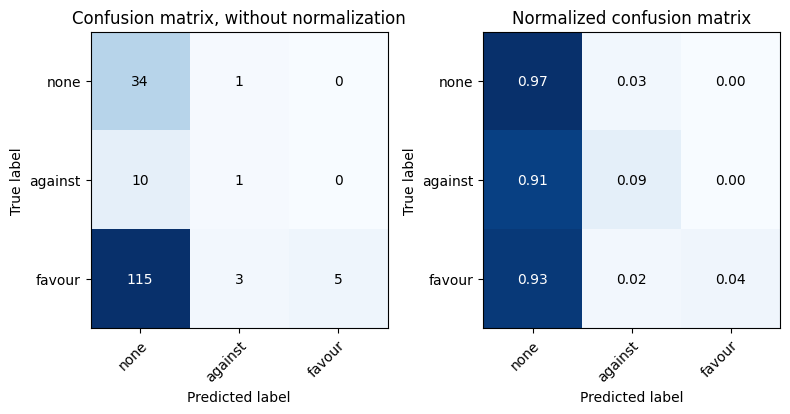

In [20]:
tw25_embed_matrix = get_embeddings_matrix(tw25_model, word_index)

m2_tw25 = train_model(lambda : model_2(tw25_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/climate/tw25_model.h5',
           class_weights=cws,
           fit_verbose = 2,
           print_summary = False
           )

#### Glove-twitter-100

Epoch 1/25
3/3 - 13s - loss: 3.4462 - accuracy: 0.2934 - precision_5: 0.2115 - recall_5: 0.1368 - val_loss: 1.9569 - val_accuracy: 0.5250 - val_precision_5: 0.5250 - val_recall_5: 0.5250 - 13s/epoch - 4s/step
Epoch 2/25
3/3 - 1s - loss: 4.1185 - accuracy: 0.3704 - precision_5: 0.3704 - recall_5: 0.3704 - val_loss: 1.1729 - val_accuracy: 0.5250 - val_precision_5: 0.5263 - val_recall_5: 0.5000 - 524ms/epoch - 175ms/step
Epoch 3/25
3/3 - 1s - loss: 1.8034 - accuracy: 0.3419 - precision_5: 0.3540 - recall_5: 0.2934 - val_loss: 1.4006 - val_accuracy: 0.1500 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - 1s/epoch - 394ms/step
Epoch 4/25
3/3 - 0s - loss: 1.1930 - accuracy: 0.3903 - precision_5: 0.3708 - recall_5: 0.1880 - val_loss: 1.1158 - val_accuracy: 0.2500 - val_precision_5: 0.0000e+00 - val_recall_5: 0.0000e+00 - 424ms/epoch - 141ms/step
Epoch 5/25
3/3 - 0s - loss: 0.9994 - accuracy: 0.3989 - precision_5: 0.4658 - recall_5: 0.2137 - val_loss: 1.0207 - val_accuracy: 0.6000 - 

c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

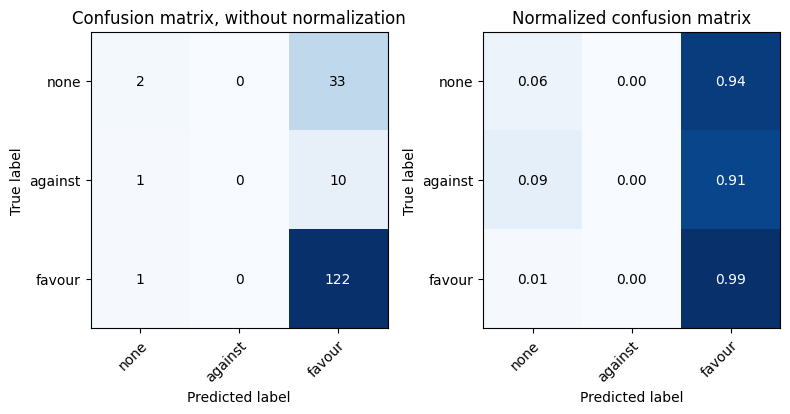

In [21]:
tw100_embed_matrix = get_embeddings_matrix(tw100_model, word_index)

m2_tw100 = train_model(lambda : model_2(tw100_embed_matrix), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/climate/tw100_model.h5',
           class_weights=cws,
           fit_verbose = 2,
           print_summary = False
           )

#### Stacked

Epoch 1/25
3/3 - 11s - loss: 3.9330 - accuracy: 0.4103 - precision_6: 0.4561 - recall_6: 0.2963 - val_loss: 6.6355 - val_accuracy: 0.5250 - val_precision_6: 0.5250 - val_recall_6: 0.5250 - 11s/epoch - 4s/step
Epoch 2/25
3/3 - 0s - loss: 4.7247 - accuracy: 0.2507 - precision_6: 0.2514 - recall_6: 0.2507 - val_loss: 6.5579 - val_accuracy: 0.4250 - val_precision_6: 0.4250 - val_recall_6: 0.4250 - 428ms/epoch - 143ms/step
Epoch 3/25
3/3 - 0s - loss: 2.4916 - accuracy: 0.3989 - precision_6: 0.4440 - recall_6: 0.3504 - val_loss: 1.2106 - val_accuracy: 0.2750 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - 430ms/epoch - 143ms/step
Epoch 4/25
3/3 - 1s - loss: 1.0579 - accuracy: 0.3989 - precision_6: 0.4861 - recall_6: 0.0997 - val_loss: 1.6083 - val_accuracy: 0.0250 - val_precision_6: 0.0000e+00 - val_recall_6: 0.0000e+00 - 628ms/epoch - 209ms/step
Epoch 5/25
3/3 - 0s - loss: 1.1221 - accuracy: 0.3447 - precision_6: 0.3251 - recall_6: 0.2251 - val_loss: 1.1713 - val_accuracy: 0.4250

c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\herre\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

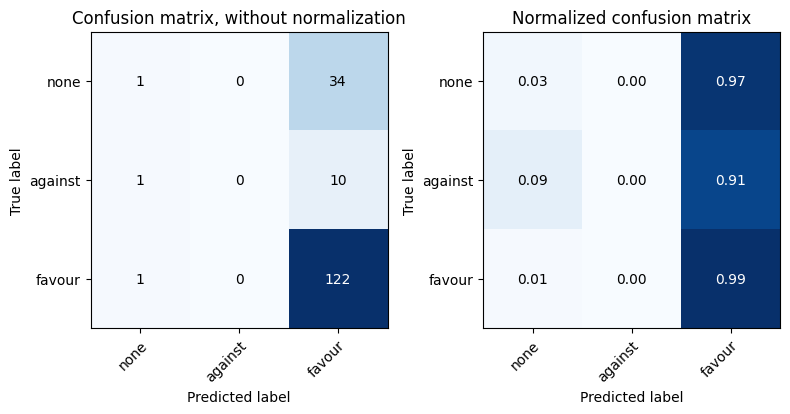

In [22]:
m2_tw_stacked = train_model(lambda : model_2(np.hstack((tw25_embed_matrix, tw100_embed_matrix))), 
           train_text_vec,
           y_train,
           test_text_vec,
           y_test,
           validation_vec,
           y_validation,
           checkpoint_path='saved_models/climate/stack_embed_model.h5',
           class_weights=cws,
           fit_verbose = 2,
           print_summary = False
           )